In [1]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# REINFORCE BASELINE VALUE FUNCTION

In [2]:
# Constants
GAMMA = 1

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [3]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ValueNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.linear1(state))
        value = self.linear2(value)
        return value

In [4]:
def update_policy(policy_network, rewards, log_probs, value_f):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient_ = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient_.append(-log_prob * (Gt - value_f))
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient_).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()
    return policy_gradient_

In [6]:
#All available environments
#print(gym.envs.registry.all()) 

In [5]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
value_net = ValueNetwork(env.observation_space.shape[0], env.action_space.n, 256)
val_optimizer = optim.Adam(value_net.parameters(), lr=3e-4)
    
max_episode_num = 3000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        value = value_net.forward(state) #Getting baseline value-function
        value = value.detach().numpy()[0,0]
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        if done:
            policy_grad = update_policy(policy_net, rewards, log_probs, value)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break
         
        state = new_state
    value_loss = torch.tensor(policy_grad, dtype = torch.float32, requires_grad = True).var()     
    val_optimizer.zero_grad()
    value_loss.backward()
    val_optimizer.step()

episode: 0, total reward: 22.0, average_reward: 22.0, length: 21
episode: 1, total reward: 31.0, average_reward: 26.5, length: 30
episode: 2, total reward: 19.0, average_reward: 24.0, length: 18
episode: 3, total reward: 70.0, average_reward: 35.5, length: 69
episode: 4, total reward: 21.0, average_reward: 32.6, length: 20
episode: 5, total reward: 15.0, average_reward: 29.667, length: 14
episode: 6, total reward: 18.0, average_reward: 28.0, length: 17
episode: 7, total reward: 15.0, average_reward: 26.375, length: 14
episode: 8, total reward: 16.0, average_reward: 25.222, length: 15
episode: 9, total reward: 13.0, average_reward: 24.0, length: 12
episode: 10, total reward: 15.0, average_reward: 23.3, length: 14
episode: 11, total reward: 11.0, average_reward: 21.3, length: 10
episode: 12, total reward: 28.0, average_reward: 22.2, length: 27
episode: 13, total reward: 20.0, average_reward: 17.2, length: 19
episode: 14, total reward: 14.0, average_reward: 16.5, length: 13
episode: 15, t

episode: 124, total reward: 18.0, average_reward: 28.3, length: 17
episode: 125, total reward: 52.0, average_reward: 31.8, length: 51
episode: 126, total reward: 20.0, average_reward: 31.7, length: 19
episode: 127, total reward: 50.0, average_reward: 32.7, length: 49
episode: 128, total reward: 27.0, average_reward: 34.2, length: 26
episode: 129, total reward: 48.0, average_reward: 37.6, length: 47
episode: 130, total reward: 34.0, average_reward: 39.5, length: 33
episode: 131, total reward: 40.0, average_reward: 39.3, length: 39
episode: 132, total reward: 48.0, average_reward: 38.0, length: 47
episode: 133, total reward: 53.0, average_reward: 39.0, length: 52
episode: 134, total reward: 35.0, average_reward: 40.7, length: 34
episode: 135, total reward: 68.0, average_reward: 42.3, length: 67
episode: 136, total reward: 37.0, average_reward: 44.0, length: 36
episode: 137, total reward: 37.0, average_reward: 42.7, length: 36
episode: 138, total reward: 21.0, average_reward: 42.1, length

episode: 247, total reward: 40.0, average_reward: 42.4, length: 39
episode: 248, total reward: 20.0, average_reward: 37.7, length: 19
episode: 249, total reward: 57.0, average_reward: 41.9, length: 56
episode: 250, total reward: 34.0, average_reward: 42.3, length: 33
episode: 251, total reward: 38.0, average_reward: 41.2, length: 37
episode: 252, total reward: 34.0, average_reward: 35.7, length: 33
episode: 253, total reward: 35.0, average_reward: 36.7, length: 34
episode: 254, total reward: 56.0, average_reward: 36.8, length: 55
episode: 255, total reward: 18.0, average_reward: 35.3, length: 17
episode: 256, total reward: 18.0, average_reward: 35.0, length: 17
episode: 257, total reward: 53.0, average_reward: 36.3, length: 52
episode: 258, total reward: 36.0, average_reward: 37.9, length: 35
episode: 259, total reward: 45.0, average_reward: 36.7, length: 44
episode: 260, total reward: 51.0, average_reward: 38.4, length: 50
episode: 261, total reward: 96.0, average_reward: 44.2, length

episode: 370, total reward: 23.0, average_reward: 46.9, length: 22
episode: 371, total reward: 20.0, average_reward: 42.4, length: 19
episode: 372, total reward: 28.0, average_reward: 40.3, length: 27
episode: 373, total reward: 30.0, average_reward: 37.4, length: 29
episode: 374, total reward: 44.0, average_reward: 36.5, length: 43
episode: 375, total reward: 52.0, average_reward: 38.3, length: 51
episode: 376, total reward: 120.0, average_reward: 45.0, length: 119
episode: 377, total reward: 72.0, average_reward: 46.6, length: 71
episode: 378, total reward: 105.0, average_reward: 54.0, length: 104
episode: 379, total reward: 40.0, average_reward: 53.4, length: 39
episode: 380, total reward: 56.0, average_reward: 56.7, length: 55
episode: 381, total reward: 32.0, average_reward: 57.9, length: 31
episode: 382, total reward: 51.0, average_reward: 60.2, length: 50
episode: 383, total reward: 37.0, average_reward: 60.9, length: 36
episode: 384, total reward: 15.0, average_reward: 58.0, le

episode: 492, total reward: 145.0, average_reward: 64.9, length: 144
episode: 493, total reward: 36.0, average_reward: 62.6, length: 35
episode: 494, total reward: 52.0, average_reward: 61.0, length: 51
episode: 495, total reward: 200.0, average_reward: 76.5, length: 199
episode: 496, total reward: 111.0, average_reward: 85.4, length: 110
episode: 497, total reward: 131.0, average_reward: 94.2, length: 130
episode: 498, total reward: 65.0, average_reward: 94.3, length: 64
episode: 499, total reward: 123.0, average_reward: 98.0, length: 122
episode: 500, total reward: 92.0, average_reward: 98.1, length: 91
episode: 501, total reward: 21.0, average_reward: 97.6, length: 20
episode: 502, total reward: 177.0, average_reward: 100.8, length: 176
episode: 503, total reward: 100.0, average_reward: 107.2, length: 99
episode: 504, total reward: 181.0, average_reward: 120.1, length: 180
episode: 505, total reward: 46.0, average_reward: 104.7, length: 45
episode: 506, total reward: 128.0, average_

episode: 611, total reward: 164.0, average_reward: 144.4, length: 163
episode: 612, total reward: 200.0, average_reward: 144.4, length: 199
episode: 613, total reward: 96.0, average_reward: 134.0, length: 95
episode: 614, total reward: 200.0, average_reward: 140.5, length: 199
episode: 615, total reward: 134.0, average_reward: 137.7, length: 133
episode: 616, total reward: 144.0, average_reward: 132.1, length: 143
episode: 617, total reward: 175.0, average_reward: 138.8, length: 174
episode: 618, total reward: 165.0, average_reward: 151.5, length: 164
episode: 619, total reward: 200.0, average_reward: 157.4, length: 199
episode: 620, total reward: 180.0, average_reward: 165.8, length: 179
episode: 621, total reward: 200.0, average_reward: 169.4, length: 199
episode: 622, total reward: 126.0, average_reward: 162.0, length: 125
episode: 623, total reward: 117.0, average_reward: 164.1, length: 116
episode: 624, total reward: 200.0, average_reward: 164.1, length: 199
episode: 625, total re

episode: 729, total reward: 185.0, average_reward: 157.7, length: 184
episode: 730, total reward: 169.0, average_reward: 171.6, length: 168
episode: 731, total reward: 200.0, average_reward: 171.6, length: 199
episode: 732, total reward: 200.0, average_reward: 176.1, length: 199
episode: 733, total reward: 200.0, average_reward: 176.1, length: 199
episode: 734, total reward: 126.0, average_reward: 177.5, length: 125
episode: 735, total reward: 200.0, average_reward: 183.5, length: 199
episode: 736, total reward: 200.0, average_reward: 183.5, length: 199
episode: 737, total reward: 200.0, average_reward: 188.0, length: 199
episode: 738, total reward: 200.0, average_reward: 188.0, length: 199
episode: 739, total reward: 140.0, average_reward: 183.5, length: 139
episode: 740, total reward: 200.0, average_reward: 186.6, length: 199
episode: 741, total reward: 200.0, average_reward: 186.6, length: 199
episode: 742, total reward: 191.0, average_reward: 185.7, length: 190
episode: 743, total 

episode: 847, total reward: 200.0, average_reward: 184.4, length: 199
episode: 848, total reward: 154.0, average_reward: 183.2, length: 153
episode: 849, total reward: 118.0, average_reward: 180.5, length: 117
episode: 850, total reward: 124.0, average_reward: 172.9, length: 123
episode: 851, total reward: 151.0, average_reward: 168.0, length: 150
episode: 852, total reward: 176.0, average_reward: 165.6, length: 175
episode: 853, total reward: 148.0, average_reward: 163.1, length: 147
episode: 854, total reward: 124.0, average_reward: 155.5, length: 123
episode: 855, total reward: 138.0, average_reward: 149.3, length: 137
episode: 856, total reward: 167.0, average_reward: 150.0, length: 166
episode: 857, total reward: 138.0, average_reward: 143.8, length: 137
episode: 858, total reward: 120.0, average_reward: 140.4, length: 119
episode: 859, total reward: 200.0, average_reward: 148.6, length: 199
episode: 860, total reward: 165.0, average_reward: 152.7, length: 164
episode: 861, total 

episode: 965, total reward: 200.0, average_reward: 160.0, length: 199
episode: 966, total reward: 200.0, average_reward: 160.0, length: 199
episode: 967, total reward: 200.0, average_reward: 160.0, length: 199
episode: 968, total reward: 200.0, average_reward: 164.9, length: 199
episode: 969, total reward: 165.0, average_reward: 165.5, length: 164
episode: 970, total reward: 131.0, average_reward: 163.3, length: 130
episode: 971, total reward: 159.0, average_reward: 166.9, length: 158
episode: 972, total reward: 200.0, average_reward: 170.5, length: 199
episode: 973, total reward: 127.0, average_reward: 172.4, length: 126
episode: 974, total reward: 200.0, average_reward: 178.2, length: 199
episode: 975, total reward: 200.0, average_reward: 178.2, length: 199
episode: 976, total reward: 106.0, average_reward: 168.8, length: 105
episode: 977, total reward: 187.0, average_reward: 167.5, length: 186
episode: 978, total reward: 200.0, average_reward: 167.5, length: 199
episode: 979, total 

episode: 1082, total reward: 200.0, average_reward: 161.5, length: 199
episode: 1083, total reward: 200.0, average_reward: 161.5, length: 199
episode: 1084, total reward: 200.0, average_reward: 168.9, length: 199
episode: 1085, total reward: 200.0, average_reward: 168.9, length: 199
episode: 1086, total reward: 200.0, average_reward: 168.9, length: 199
episode: 1087, total reward: 87.0, average_reward: 157.6, length: 86
episode: 1088, total reward: 200.0, average_reward: 160.3, length: 199
episode: 1089, total reward: 200.0, average_reward: 171.5, length: 199
episode: 1090, total reward: 200.0, average_reward: 185.6, length: 199
episode: 1091, total reward: 200.0, average_reward: 188.7, length: 199
episode: 1092, total reward: 135.0, average_reward: 182.2, length: 134
episode: 1093, total reward: 120.0, average_reward: 174.2, length: 119
episode: 1094, total reward: 200.0, average_reward: 174.2, length: 199
episode: 1095, total reward: 160.0, average_reward: 170.2, length: 159
episode:

episode: 1198, total reward: 200.0, average_reward: 189.8, length: 199
episode: 1199, total reward: 200.0, average_reward: 189.8, length: 199
episode: 1200, total reward: 165.0, average_reward: 186.3, length: 164
episode: 1201, total reward: 200.0, average_reward: 188.1, length: 199
episode: 1202, total reward: 200.0, average_reward: 188.1, length: 199
episode: 1203, total reward: 144.0, average_reward: 185.9, length: 143
episode: 1204, total reward: 164.0, average_reward: 187.3, length: 163
episode: 1205, total reward: 120.0, average_reward: 179.3, length: 119
episode: 1206, total reward: 200.0, average_reward: 179.3, length: 199
episode: 1207, total reward: 200.0, average_reward: 179.3, length: 199
episode: 1208, total reward: 200.0, average_reward: 179.3, length: 199
episode: 1209, total reward: 200.0, average_reward: 179.3, length: 199
episode: 1210, total reward: 200.0, average_reward: 182.8, length: 199
episode: 1211, total reward: 200.0, average_reward: 182.8, length: 199
episod

episode: 1314, total reward: 200.0, average_reward: 189.5, length: 199
episode: 1315, total reward: 200.0, average_reward: 189.5, length: 199
episode: 1316, total reward: 200.0, average_reward: 189.5, length: 199
episode: 1317, total reward: 134.0, average_reward: 182.9, length: 133
episode: 1318, total reward: 200.0, average_reward: 188.5, length: 199
episode: 1319, total reward: 149.0, average_reward: 188.3, length: 148
episode: 1320, total reward: 200.0, average_reward: 188.3, length: 199
episode: 1321, total reward: 200.0, average_reward: 188.3, length: 199
episode: 1322, total reward: 200.0, average_reward: 188.3, length: 199
episode: 1323, total reward: 184.0, average_reward: 186.7, length: 183
episode: 1324, total reward: 200.0, average_reward: 186.7, length: 199
episode: 1325, total reward: 200.0, average_reward: 186.7, length: 199
episode: 1326, total reward: 200.0, average_reward: 186.7, length: 199
episode: 1327, total reward: 200.0, average_reward: 193.3, length: 199
episod

episode: 1430, total reward: 200.0, average_reward: 192.5, length: 199
episode: 1431, total reward: 199.0, average_reward: 192.4, length: 198
episode: 1432, total reward: 200.0, average_reward: 192.4, length: 199
episode: 1433, total reward: 182.0, average_reward: 190.6, length: 181
episode: 1434, total reward: 200.0, average_reward: 191.2, length: 199
episode: 1435, total reward: 200.0, average_reward: 191.2, length: 199
episode: 1436, total reward: 162.0, average_reward: 187.4, length: 161
episode: 1437, total reward: 200.0, average_reward: 190.3, length: 199
episode: 1438, total reward: 200.0, average_reward: 190.3, length: 199
episode: 1439, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1440, total reward: 114.0, average_reward: 185.7, length: 113
episode: 1441, total reward: 176.0, average_reward: 183.4, length: 175
episode: 1442, total reward: 159.0, average_reward: 179.3, length: 158
episode: 1443, total reward: 200.0, average_reward: 181.1, length: 199
episod

episode: 1546, total reward: 133.0, average_reward: 180.1, length: 132
episode: 1547, total reward: 200.0, average_reward: 180.1, length: 199
episode: 1548, total reward: 200.0, average_reward: 188.6, length: 199
episode: 1549, total reward: 200.0, average_reward: 189.2, length: 199
episode: 1550, total reward: 200.0, average_reward: 189.2, length: 199
episode: 1551, total reward: 200.0, average_reward: 189.6, length: 199
episode: 1552, total reward: 200.0, average_reward: 190.4, length: 199
episode: 1553, total reward: 200.0, average_reward: 190.4, length: 199
episode: 1554, total reward: 200.0, average_reward: 190.4, length: 199
episode: 1555, total reward: 200.0, average_reward: 193.3, length: 199
episode: 1556, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1557, total reward: 176.0, average_reward: 197.6, length: 175
episode: 1558, total reward: 156.0, average_reward: 193.2, length: 155
episode: 1559, total reward: 179.0, average_reward: 191.1, length: 178
episod

episode: 1662, total reward: 200.0, average_reward: 189.1, length: 199
episode: 1663, total reward: 200.0, average_reward: 189.1, length: 199
episode: 1664, total reward: 200.0, average_reward: 189.1, length: 199
episode: 1665, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1666, total reward: 174.0, average_reward: 197.4, length: 173
episode: 1667, total reward: 200.0, average_reward: 197.4, length: 199
episode: 1668, total reward: 200.0, average_reward: 197.4, length: 199
episode: 1669, total reward: 109.0, average_reward: 188.3, length: 108
episode: 1670, total reward: 200.0, average_reward: 188.3, length: 199
episode: 1671, total reward: 200.0, average_reward: 188.3, length: 199
episode: 1672, total reward: 182.0, average_reward: 186.5, length: 181
episode: 1673, total reward: 200.0, average_reward: 186.5, length: 199
episode: 1674, total reward: 200.0, average_reward: 186.5, length: 199
episode: 1675, total reward: 200.0, average_reward: 186.5, length: 199
episod

episode: 1778, total reward: 200.0, average_reward: 189.7, length: 199
episode: 1779, total reward: 200.0, average_reward: 189.7, length: 199
episode: 1780, total reward: 200.0, average_reward: 189.7, length: 199
episode: 1781, total reward: 200.0, average_reward: 189.7, length: 199
episode: 1782, total reward: 200.0, average_reward: 192.1, length: 199
episode: 1783, total reward: 200.0, average_reward: 192.1, length: 199
episode: 1784, total reward: 200.0, average_reward: 192.1, length: 199
episode: 1785, total reward: 177.0, average_reward: 193.3, length: 176
episode: 1786, total reward: 200.0, average_reward: 197.7, length: 199
episode: 1787, total reward: 200.0, average_reward: 197.7, length: 199
episode: 1788, total reward: 87.0, average_reward: 186.4, length: 86
episode: 1789, total reward: 200.0, average_reward: 186.4, length: 199
episode: 1790, total reward: 200.0, average_reward: 186.4, length: 199
episode: 1791, total reward: 200.0, average_reward: 186.4, length: 199
episode:

episode: 1894, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1895, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1896, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1897, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1898, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1899, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1900, total reward: 200.0, average_reward: 199.4, length: 199
episode: 1901, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1902, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1903, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1904, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1905, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1906, total reward: 200.0, average_reward: 200.0, length: 199
episode: 1907, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 2010, total reward: 200.0, average_reward: 186.8, length: 199
episode: 2011, total reward: 200.0, average_reward: 192.6, length: 199
episode: 2012, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2013, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2014, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2015, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2016, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2017, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2018, total reward: 200.0, average_reward: 195.6, length: 199
episode: 2019, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2020, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2021, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2022, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2023, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 2126, total reward: 200.0, average_reward: 189.2, length: 199
episode: 2127, total reward: 200.0, average_reward: 189.2, length: 199
episode: 2128, total reward: 200.0, average_reward: 189.2, length: 199
episode: 2129, total reward: 157.0, average_reward: 184.9, length: 156
episode: 2130, total reward: 200.0, average_reward: 184.9, length: 199
episode: 2131, total reward: 200.0, average_reward: 184.9, length: 199
episode: 2132, total reward: 200.0, average_reward: 188.8, length: 199
episode: 2133, total reward: 183.0, average_reward: 194.0, length: 182
episode: 2134, total reward: 186.0, average_reward: 192.6, length: 185
episode: 2135, total reward: 157.0, average_reward: 188.3, length: 156
episode: 2136, total reward: 152.0, average_reward: 183.5, length: 151
episode: 2137, total reward: 186.0, average_reward: 182.1, length: 185
episode: 2138, total reward: 171.0, average_reward: 179.2, length: 170
episode: 2139, total reward: 200.0, average_reward: 183.5, length: 199
episod

episode: 2242, total reward: 200.0, average_reward: 179.4, length: 199
episode: 2243, total reward: 200.0, average_reward: 179.4, length: 199
episode: 2244, total reward: 200.0, average_reward: 179.4, length: 199
episode: 2245, total reward: 200.0, average_reward: 179.4, length: 199
episode: 2246, total reward: 189.0, average_reward: 178.3, length: 188
episode: 2247, total reward: 179.0, average_reward: 176.2, length: 178
episode: 2248, total reward: 200.0, average_reward: 193.1, length: 199
episode: 2249, total reward: 200.0, average_reward: 194.7, length: 199
episode: 2250, total reward: 200.0, average_reward: 196.8, length: 199
episode: 2251, total reward: 200.0, average_reward: 196.8, length: 199
episode: 2252, total reward: 200.0, average_reward: 196.8, length: 199
episode: 2253, total reward: 200.0, average_reward: 196.8, length: 199
episode: 2254, total reward: 200.0, average_reward: 196.8, length: 199
episode: 2255, total reward: 200.0, average_reward: 196.8, length: 199
episod

episode: 2358, total reward: 200.0, average_reward: 187.6, length: 199
episode: 2359, total reward: 200.0, average_reward: 187.6, length: 199
episode: 2360, total reward: 200.0, average_reward: 193.5, length: 199
episode: 2361, total reward: 200.0, average_reward: 193.5, length: 199
episode: 2362, total reward: 200.0, average_reward: 193.5, length: 199
episode: 2363, total reward: 200.0, average_reward: 193.5, length: 199
episode: 2364, total reward: 200.0, average_reward: 193.5, length: 199
episode: 2365, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2366, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2367, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2368, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2369, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2370, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2371, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 2474, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2475, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2476, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2477, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2478, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2479, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2480, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2481, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2482, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2483, total reward: 192.0, average_reward: 199.2, length: 191
episode: 2484, total reward: 200.0, average_reward: 199.2, length: 199
episode: 2485, total reward: 200.0, average_reward: 199.2, length: 199
episode: 2486, total reward: 200.0, average_reward: 199.2, length: 199
episode: 2487, total reward: 200.0, average_reward: 199.2, length: 199
episod

episode: 2590, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2591, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2592, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2593, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2594, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2595, total reward: 200.0, average_reward: 190.6, length: 199
episode: 2596, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2597, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2598, total reward: 152.0, average_reward: 195.2, length: 151
episode: 2599, total reward: 200.0, average_reward: 195.2, length: 199
episode: 2600, total reward: 200.0, average_reward: 195.2, length: 199
episode: 2601, total reward: 134.0, average_reward: 188.6, length: 133
episode: 2602, total reward: 186.0, average_reward: 187.2, length: 185
episode: 2603, total reward: 200.0, average_reward: 187.2, length: 199
episod

episode: 2706, total reward: 188.0, average_reward: 180.6, length: 187
episode: 2707, total reward: 194.0, average_reward: 187.4, length: 193
episode: 2708, total reward: 200.0, average_reward: 187.4, length: 199
episode: 2709, total reward: 200.0, average_reward: 187.4, length: 199
episode: 2710, total reward: 200.0, average_reward: 187.4, length: 199
episode: 2711, total reward: 173.0, average_reward: 190.7, length: 172
episode: 2712, total reward: 200.0, average_reward: 195.5, length: 199
episode: 2713, total reward: 144.0, average_reward: 189.9, length: 143
episode: 2714, total reward: 200.0, average_reward: 189.9, length: 199
episode: 2715, total reward: 155.0, average_reward: 185.4, length: 154
episode: 2716, total reward: 200.0, average_reward: 186.6, length: 199
episode: 2717, total reward: 200.0, average_reward: 187.2, length: 199
episode: 2718, total reward: 200.0, average_reward: 187.2, length: 199
episode: 2719, total reward: 171.0, average_reward: 184.3, length: 170
episod

episode: 2822, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2823, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2824, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2825, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2826, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2827, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2828, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2829, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2830, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2831, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2832, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2833, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2834, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2835, total reward: 200.0, average_reward: 200.0, length: 199
episod

episode: 2938, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2939, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2940, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2941, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2942, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2943, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2944, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2945, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2946, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2947, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2948, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2949, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2950, total reward: 200.0, average_reward: 200.0, length: 199
episode: 2951, total reward: 200.0, average_reward: 200.0, length: 199
episod

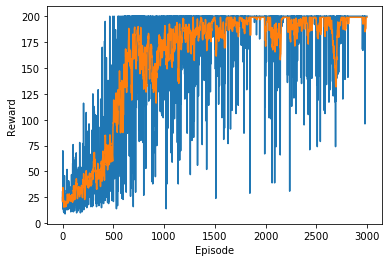

Varince of reward = 3836.988218222222


In [6]:
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
plt.plot(all_rewards)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(all_rewards)))

In [7]:
df = pd.DataFrame()
df['rewards'] = all_rewards
df['mean10_rewards'] = avg_numsteps

In [8]:
df.to_csv('D:/Reinforcement_Learning/df_reinforce_baseline.csv', index=False)